In [146]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import camelot
import pickle
from IPython.display import clear_output
import seaborn as sns

In [223]:
def extract_data():
    r = requests.get(
        "https://www.massport.com/logan-airport/about-logan/noise-abatement/complaints-by-townss/",
        headers={"user-agent": "parser/0.0.1"},
    )
    soup = BeautifulSoup(r.content, "html.parser")
    dfs = []
    base_url = "https://www.massport.com"

    total_to_process = len(soup.select("table a"))
    processed = 0

    tables = soup.find_all("table")
    for table in tables:
        year = table.find(string=re.compile(".*Noise Complaint Reports by Towns"))[0:4]
        links = table.find_all("a")
        for link in links:
            month = link.text.strip()
            link = base_url + link["href"]
            # tell camelot to read the full page because some of the tables its cutting
            # off the bottom and top of the table
            # some rows were being split into multiple rows, so setting row_tol to 5 fixed that
            df = camelot.read_pdf(link, flavor="stream", strip_text=",", table_areas=['0,800,500,0'], row_tol=5)[0].df

            # delete the total rows at the bottom
            # some september months they called it "September" instead of "Totals"
            df = df[~df[0].isin(["Totals:", "Communities:", "Communities", "Totals", "September"])]


            # make the first row with the word "Community" the header and delete the title rows above it
            header_row_index = df[0].eq("Community").idxmax()
            df.columns = df.iloc[header_row_index].values
            df = df[header_row_index + 1:]


            df["date"] = pd.to_datetime(f"{year} {month}")
            df["link"] = link
            df.rename(columns={"Calls": "complaints", "Callers": "complainants"}, inplace=True)
            df.columns = map(str.lower, df.columns)
            # sometimes the parser interprets lowercase i as I
            df["community"] = df["community"].replace({"WIinchester": "Winchester", "WInthrop": "Winthrop", "MIlton": "Milton"})

            dfs.append(df)
            processed += 1
            clear_output(wait=True)
            print(f"[{processed * '='}{(total_to_process - processed) * ' '}]")

    # some yearly summaries are included by mistake https://www.massport.com/media/1297/2013_monthlycomplaintswebapril.pdf
    del dfs[109:113]

    return dfs

data = extract_data()
file = open("data.pkl", "wb")
pickle.dump(data, file)

[===================================================================================================================================]


In [226]:
dfs = pickle.load(open("data.pkl", "rb"))

data = pd.concat(dfs)
data["complainants"] = pd.to_numeric(data["complainants"])
data["complaints"] = pd.to_numeric(data["complaints"])
data["addresses"] = pd.to_numeric(data["addresses"])
data["residents"] = pd.to_numeric(data["residents"])
data["households"] = pd.to_numeric(data["households"])

# some dates are missing reports from some communities
data = data.set_index(["community", "date"])
data = data[~data.index.duplicated(keep="first")] # there's one duplicate row
new_index = pd.MultiIndex.from_product(
    data.index.levels,
    names=data.index.names,
)

# I assume missing reports means zero complaints
data = data.reindex(index=new_index, fill_value=0)

# filter out communities with very low total complaints
data = data.groupby("community").filter(lambda x: x["complaints"].sum() > 20000)
data = data[["complaints"]]
data.to_csv("../data.csv")

[Text(0.5, 1.0, 'Airplane noise complaints in Somerville')]

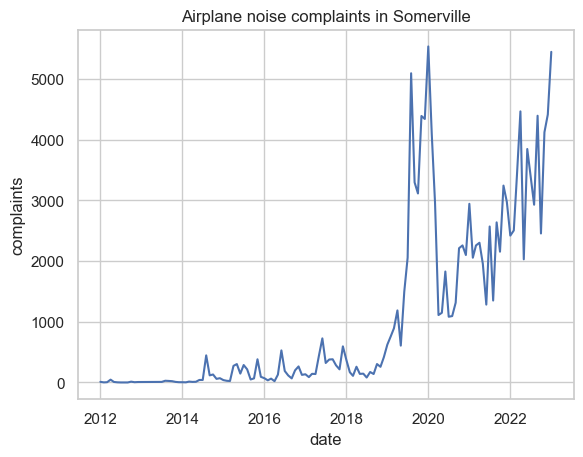

In [227]:
sns.set_theme(style="whitegrid")
sns.lineplot(
    data=data["complaints"]["Somerville"]
).set(title="Airplane noise complaints in Somerville")